<a href="https://colab.research.google.com/github/CLKim00/Machine-Learning/blob/main/DL/CarSalesForecast_Multi_LayerPerceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

In [4]:
df_cars = pd.read_csv('sales-cars.csv')

df_cars.head()

,Month,Sales
0,2016-01,266
1,2016-02,146
2,2016-03,183
3,2016-04,119
4,2016-05,180


In [5]:
# convert the month column of the data to date format
df_cars.index = pd.to_datetime(df_cars.Month, format='%Y-%m')
df_cars = df_cars.resample('M').sum()

In [7]:
df_cars.head()

,Sales
Month,
2016-01-31,266
2016-02-29,146
2016-03-31,183
2016-04-30,119
2016-05-31,180


<Axes: xlabel='Month'>

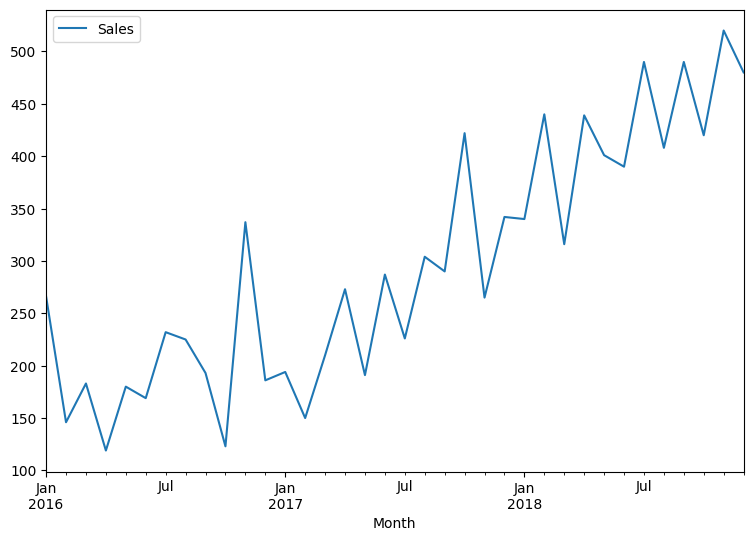

In [9]:
df_cars.plot(figsize=(9, 6))

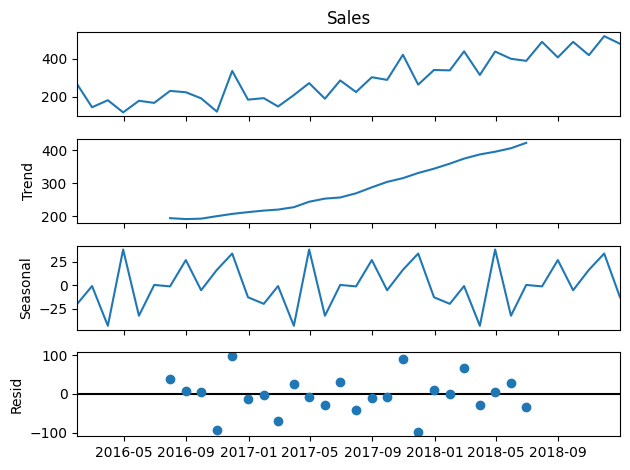

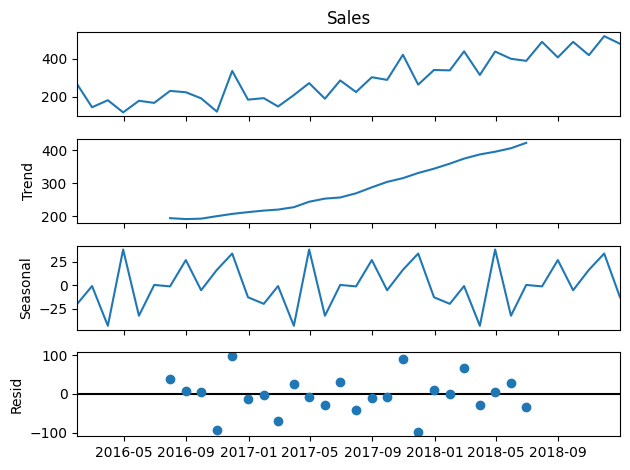

In [11]:
# Seasonal decompose
results = seasonal_decompose(df_cars['Sales'])
results.plot()

In [12]:
# train test split
train = df_cars[:-6]
test = df_cars[-6:]

In [13]:
train.head()

,Sales
Month,
2016-01-31,266
2016-02-29,146
2016-03-31,183
2016-04-30,119
2016-05-31,180


In [15]:
test.head()

,Sales
Month,
2018-07-31,490
2018-08-31,408
2018-09-30,490
2018-10-31,420
2018-11-30,520


In [16]:
# generate lags

def generate_lag(df, n):
    X, y = [], []
    for i in range(len(df) - n):
        X.append(df[i:i+n])
        y.append(df[n+i])

    return np.array(X), np.array(y), np.array(y[-n:]).reshape(1, n)

In [17]:
X, y, last_batch_values = generate_lag(train.Sales.values, 12)

In [18]:
X

array([[266, 146, 183, 119, 180, 169, 232, 225, 193, 123, 337, 186],
       [146, 183, 119, 180, 169, 232, 225, 193, 123, 337, 186, 194],
       [183, 119, 180, 169, 232, 225, 193, 123, 337, 186, 194, 150],
       [119, 180, 169, 232, 225, 193, 123, 337, 186, 194, 150, 210],
       [180, 169, 232, 225, 193, 123, 337, 186, 194, 150, 210, 273],
       [169, 232, 225, 193, 123, 337, 186, 194, 150, 210, 273, 191],
       [232, 225, 193, 123, 337, 186, 194, 150, 210, 273, 191, 287],
       [225, 193, 123, 337, 186, 194, 150, 210, 273, 191, 287, 226],
       [193, 123, 337, 186, 194, 150, 210, 273, 191, 287, 226, 304],
       [123, 337, 186, 194, 150, 210, 273, 191, 287, 226, 304, 290],
       [337, 186, 194, 150, 210, 273, 191, 287, 226, 304, 290, 422],
       [186, 194, 150, 210, 273, 191, 287, 226, 304, 290, 422, 265],
       [194, 150, 210, 273, 191, 287, 226, 304, 290, 422, 265, 342],
       [150, 210, 273, 191, 287, 226, 304, 290, 422, 265, 342, 340],
       [210, 273, 191, 287, 226, 3

In [19]:
y

array([194, 150, 210, 273, 191, 287, 226, 304, 290, 422, 265, 342, 340,
       440, 316, 439, 401, 390])

In [20]:
last_batch_values

array([[226, 304, 290, 422, 265, 342, 340, 440, 316, 439, 401, 390]])

In [21]:
# Build model

def mlp_model(input_, y_, epochs=1000):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(100, activation='relu', input_dim=input_.shape[1]))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer='adam', loss='mse')
    print(model.fit(input_, y_, epochs=epochs))
    return model

In [22]:
model = mlp_model(X, y, epochs=3000)
model

Epoch 1/3000
1/1 [==============================] - 2s 2s/step - loss: 151198.6250
Epoch 2/3000
1/1 [==============================] - 0s 8ms/step - loss: 135124.3125
Epoch 3/3000
1/1 [==============================] - 0s 9ms/step - loss: 120054.0938
Epoch 4/3000
1/1 [==============================] - 0s 7ms/step - loss: 105957.8906
Epoch 5/3000
1/1 [==============================] - 0s 10ms/step - loss: 92825.9062
Epoch 6/3000
1/1 [==============================] - 0s 9ms/step - loss: 80780.8906
Epoch 7/3000
1/1 [==============================] - 0s 8ms/step - loss: 69733.2812
Epoch 8/3000
1/1 [==============================] - 0s 8ms/step - loss: 59664.4180
Epoch 9/3000
1/1 [==============================] - 0s 7ms/step - loss: 50486.7148
Epoch 10/3000
1/1 [==============================] - 0s 8ms/step - loss: 42210.4492
Epoch 11/3000
1/1 [==============================] - 0s 8ms/step - loss: 34842.1406
Epoch 12/3000
1/1 [==============================] - 0s 8ms/step - loss: 28369.57

In [23]:
# forecast
def forecast_function(model, last_batch, n):
    in_value = last_batch.copy()
    preds = []
    for i in range(n):
        p = model.predict(in_value)
        preds.append(p.ravel())
        in_value = np.append(in_value, p)[1:].reshape(last_batch.shape)
    return np.array(preds).ravel()

In [24]:
pred = forecast_function(model, last_batch_values, 6)

1/1 [==============================] - 0s 39ms/step


In [25]:
pred

array([466.24664, 497.046  , 516.31665, 388.82263, 645.57874, 544.1652 ],
      dtype=float32)

In [26]:
test['Predicted_Sales'] = pred

In [27]:
test.head()

,Sales,Predicted_Sales
Month,,
2018-07-31,490,466.246643
2018-08-31,408,497.045990
2018-09-30,490,516.316650
2018-10-31,420,388.822632
2018-11-30,520,645.578735


<Axes: xlabel='Month'>

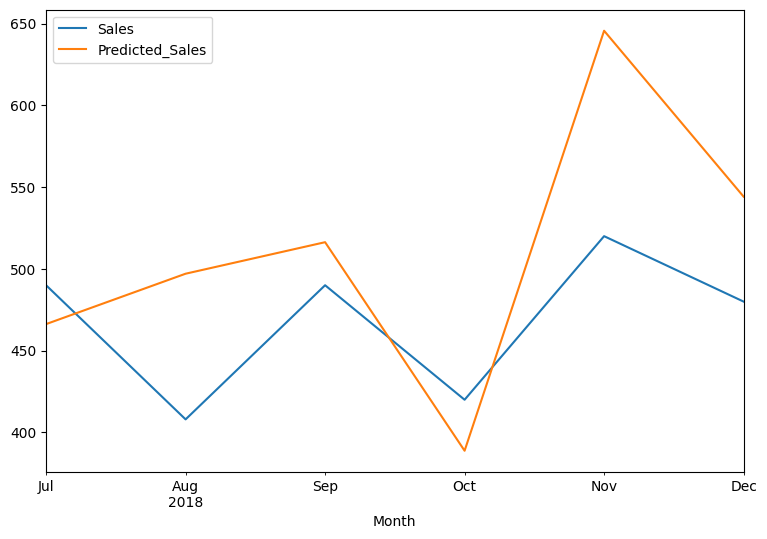

In [28]:
test.plot(figsize=(9, 6))

In [29]:
def error_function(df, column_1, column_2):
    data = df.copy()
    my_list = []
    for i in range(len(data)):
        x = (data[column_2][i] * 100) / data[column_1][i]
        if x >= 100:
            error = x - 100
            my_list.append(error)
        else:
            error = 100 - x
            my_list.append(error)
    data['error_percentage'] = my_list
    return data

In [30]:
column_1 = 'Sales'
column_2 = 'Predicted_Sales'
df_new = error_function(test, column_1, column_2)

In [31]:
df_new

,Sales,Predicted_Sales,error_percentage
Month,,,
2018-07-31,490,466.246643,4.847624
2018-08-31,408,497.045990,21.824998
2018-09-30,490,516.316650,5.370745
2018-10-31,420,388.822632,7.423183
2018-11-30,520,645.578735,24.149757
2018-12-31,480,544.165222,13.367755


In [32]:
def mean_error(df, error_column):
    total = 0
    for i in range(len(df)):
        total += df[error_column][i]
    mean_error_ = total / (len(df))
    return mean_error_

In [33]:
error_rate = mean_error(df_new, 'error_percentage')

In [34]:
error_rate

12.830676783535495

In [35]:
sum_of_actual_sales = sum(df_new.Sales.values)
sum_of_actual_sales

2808

In [36]:
sum_of_predicted_sales = sum(df_new.Predicted_Sales.values)
sum_of_predicted_sales

3058.1758728027344

In [38]:
rate_of_actual_and_predict_sums = (sum_of_predicted_sales * 100) / sum_of_actual_sales

if rate_of_actual_and_predict_sums >= 100:
    total_percentage = rate_of_actual_and_predict_sums - 100
else:
    total_percentage = 100 - rate_of_actual_and_predict_sums

print('Percentage error: ', total_percentage)

Percentage error:  8.909397179584559


# Reference
## Car Sales Forecast with Multi-Layer Perceptron, SONGUL ERDEM GULER
https://www.kaggle.com/code/songulerdem/car-sales-forecast-with-multi-layer-perceptron/notebook